# LAB 3: Warehouse Robot Navigation Using MDP and Value Iteration

### The Problem:
- In modern warehouses (like Amazon’s fulfillment centers), robots navigate grid-like spaces to pick up and deliver packages efficiently.

### These robots need to:

- Avoid obstacles (like shelves),

- Find the shortest and safest path to deliver packages,

- Avoid collisions or repeated unnecessary moves,

- Handle uncertainty in movement (sometimes they don’t move exactly as intended),

- Adapt to changing goals (dynamic targets),

- React to dynamic conditions like humans walking around.

## What is an MDP?
A Markov Decision Process (MDP) models decision-making where outcomes are partly random and partly controlled by an agent.

- States: Positions of the robot (each grid cell),

- Actions: Possible moves (up, down, left, right),

- Transition probabilities: Chance that an action leads to a certain next state (e.g., intended move 90%, unintended 10%),

- Rewards: Numerical values representing the desirability of outcomes (e.g., reward for reaching goal, penalty for hitting shelf).

## What is Value Iteration?
- A method to compute the optimal policy (best action to take from each state) in an MDP.

- It iteratively updates the value of each state based on expected rewards and transitions.

- The output: an optimal policy that minimizes time and penalties, guiding the robot on the best path.

## Our Objective of this Lab
- Model the warehouse navigation as an MDP with states, actions, transitions, and rewards.

- Solve the MDP using value iteration to find the optimal path.

- Handle obstacles and stochastic (random) movements.

### Experiment with:

- Directional constraints (e.g., only left-to-right moves),

- Dynamic goals that change,

- Human worker zones with high penalties and temporal constraints.

Current Goal Position: (3, 0)

📍 Optimal Policy Grid:
[['↓' '←' '←' '←' '←']
 ['↓' '↓' '↑' '↑' '↓']
 ['↓' '←' '←' '→' '↓']
 ['↑' '←' '←' '←' '↓']
 ['↑' '←' '←' '←' '←']]


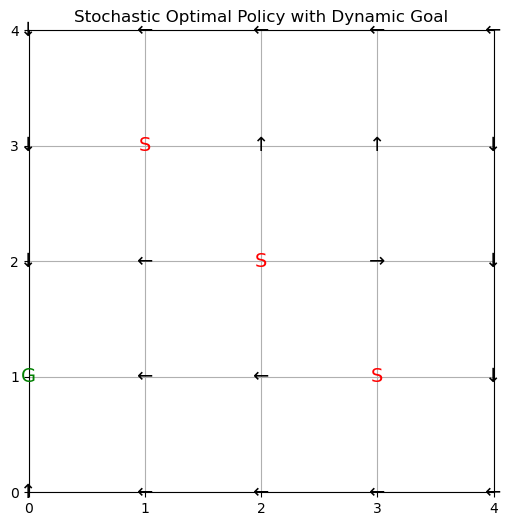

In [1]:
import numpy as np
import mdptoolbox
import matplotlib.pyplot as plt
import random

# Grid Parameters
rows, cols = 5, 5
num_states = rows * cols
shelves = [(1, 1), (2, 2), (3, 3)]  # Obstacle positions
actions = ['up', 'down', 'left', 'right']
num_actions = len(actions)
movement = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}

# Convert (x, y) to index
def to_index(x, y):
    return x * cols + y

# Set dynamic goal avoiding shelves
def set_dynamic_goal():
    possible = [(i, j) for i in range(rows) for j in range(cols) if (i, j) not in shelves]
    return random.choice(possible)

# Random initial goal
goal_state = set_dynamic_goal()
print("Current Goal Position:", goal_state)

# Initialize transition and reward matrices
P = [np.zeros((num_states, num_states)) for _ in range(num_actions)]
R = np.zeros((num_states, num_actions))

# Build MDP matrices with stochastic transitions
for action_idx, action in enumerate(actions):
    dx, dy = movement[action]
    for x in range(rows):
        for y in range(cols):
            current_state = to_index(x, y)

            if (x, y) == goal_state:
                P[action_idx][current_state, current_state] = 1
                R[current_state, action_idx] = 10  # reward for goal
                continue

            outcomes = []
            # Intended move (90%)
            new_x, new_y = x + dx, y + dy
            if (new_x, new_y) in shelves or not (0 <= new_x < rows and 0 <= new_y < cols):
                new_state = current_state
                reward = -5 if (new_x, new_y) in shelves else -1
            else:
                new_state = to_index(new_x, new_y)
                reward = -1
            outcomes.append((new_state, 0.9, reward))

            # Misstep moves (10% divided equally)
            other_actions = [a for i, a in enumerate(actions) if i != action_idx]
            for mis_action in other_actions:
                mx, my = movement[mis_action]
                new_x, new_y = x + mx, y + my
                if (new_x, new_y) in shelves or not (0 <= new_x < rows and 0 <= new_y < cols):
                    mis_state = current_state
                    mis_reward = -5 if (new_x, new_y) in shelves else -1
                else:
                    mis_state = to_index(new_x, new_y)
                    mis_reward = -1
                outcomes.append((mis_state, 0.1 / 3, mis_reward))

            # Update transition matrix and expected reward
            for s_next, prob, rew in outcomes:
                P[action_idx][current_state, s_next] += prob
                R[current_state, action_idx] += prob * rew

# Run value iteration
vi = mdptoolbox.mdp.ValueIteration(P, R, 0.9)
vi.run()

# Reshape policy to grid form
policy_grid = np.array(vi.policy).reshape((rows, cols))
action_symbols = ['↑', '↓', '←', '→']
policy_symbols = np.array([[action_symbols[a] for a in row] for row in policy_grid])
print("\n📍 Optimal Policy Grid:")
print(policy_symbols)

# Plot policy grid
plt.figure(figsize=(6, 6))
for x in range(rows):
    for y in range(cols):
        idx = to_index(x, y)
        if (x, y) == goal_state:
            plt.text(y, rows - x - 1, 'G', ha='center', va='center', fontsize=14, color='green')
        elif (x, y) in shelves:
            plt.text(y, rows - x - 1, 'S', ha='center', va='center', fontsize=14, color='red')
        else:
            plt.text(y, rows - x - 1, action_symbols[vi.policy[idx]], ha='center', va='center', fontsize=14)
plt.xticks(range(cols))
plt.yticks(range(rows))
plt.grid(True)
plt.title("Stochastic Optimal Policy with Dynamic Goal")
plt.show()


### Task 1: Restrict Movement Direction (e.g., only left-to-right)

- The robot must only move from left to right in the grid (e.g., no up/down/left moves allowed).

### Why:
- In some warehouse aisles, movement might be constrained to one direction to avoid collisions.

### Modify:

- In the transition matrix, block all moves except 'right' by making non-'right' moves lead to no movement with penalty.

- Only allow 'right' moves to progress normally.

Current Goal Position: (2, 4)

Optimal Policy Grid (Left-to-Right Movement Only):
[['↑' '↑' '↑' '↑' '↑']
 ['↑' '↑' '↑' '↑' '↑']
 ['↑' '↑' '→' '→' '↑']
 ['↑' '↑' '↑' '↑' '↑']
 ['↑' '↑' '↑' '↑' '↑']]


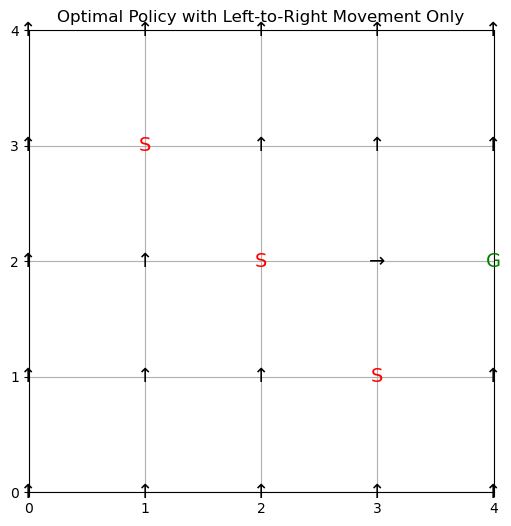

In [7]:
import numpy as np
import mdptoolbox
import matplotlib.pyplot as plt
import random

rows, cols = 5, 5
num_states = rows * cols
shelves = [(1, 1), (2, 2), (3, 3)]
actions = ['up', 'down', 'left', 'right']
num_actions = len(actions)
movement = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}

def to_index(x, y):
    return x * cols + y

def set_dynamic_goal():
    possible = [(i, j) for i in range(rows) for j in range(cols) if (i, j) not in shelves]
    return random.choice(possible)

goal_state = set_dynamic_goal()
print("Current Goal Position:", goal_state)

P = [np.zeros((num_states, num_states)) for _ in range(num_actions)]
R = np.zeros((num_states, num_actions))

for action_idx, action in enumerate(actions):
    dx, dy = movement[action]
    for x in range(rows):
        for y in range(cols):
            current_state = to_index(x, y)

            if (x, y) == goal_state:
                P[action_idx][current_state, current_state] = 1
                R[current_state, action_idx] = 10
                continue

            # Restrict to only 'right' moves allowed
            if action != 'right':
                # No movement, penalty for invalid move
                P[action_idx][current_state, current_state] = 1
                R[current_state, action_idx] = -1
                continue

            # Intended right move
            new_x, new_y = x + dx, y + dy
            if (new_x, new_y) in shelves or not (0 <= new_x < rows and 0 <= new_y < cols):
                new_state = current_state
                reward = -5 if (new_x, new_y) in shelves else -1
            else:
                new_state = to_index(new_x, new_y)
                reward = -1

            P[action_idx][current_state, new_state] = 1
            R[current_state, action_idx] = reward

vi = mdptoolbox.mdp.ValueIteration(P, R, 0.9)
vi.run()

policy_grid = np.array(vi.policy).reshape((rows, cols))
action_symbols = ['↑', '↓', '←', '→']
policy_symbols = np.array([[action_symbols[a] for a in row] for row in policy_grid])
print("\nOptimal Policy Grid (Left-to-Right Movement Only):")
print(policy_symbols)

plt.figure(figsize=(6, 6))
for x in range(rows):
    for y in range(cols):
        idx = to_index(x, y)
        if (x, y) == goal_state:
            plt.text(y, rows - x - 1, 'G', ha='center', va='center', fontsize=14, color='green')
        elif (x, y) in shelves:
            plt.text(y, rows - x - 1, 'S', ha='center', va='center', fontsize=14, color='red')
        else:
            plt.text(y, rows - x - 1, action_symbols[vi.policy[idx]], ha='center', va='center', fontsize=14)
plt.xticks(range(cols))
plt.yticks(range(rows))
plt.grid(True)
plt.title("Optimal Policy with Left-to-Right Movement Only")
plt.show()


### Task 2: Dynamic Goals (Switch delivery target every few episodes)

- The delivery location (goal) changes every few episodes — the robot must adapt and find the new optimal path.

### Why:
- In warehouses, delivery locations change depending on orders.

### Modify:

- Run multiple iterations (episodes).

- For each episode, pick a new goal.

- Rebuild transition and reward matrices for that goal.

- Run value iteration to get updated policies.



In [6]:
import numpy as np
import mdptoolbox
import matplotlib.pyplot as plt
import random

rows, cols = 5, 5
num_states = rows * cols
shelves = [(1, 1), (2, 2), (3, 3)]
actions = ['up', 'down', 'left', 'right']
num_actions = len(actions)
movement = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}

def to_index(x, y):
    return x * cols + y

def set_dynamic_goal():
    possible = [(i, j) for i in range(rows) for j in range(cols) if (i, j) not in shelves]
    return random.choice(possible)

num_episodes = 5

for episode in range(num_episodes):
    print(f"\n--- Episode {episode + 1} ---")
    goal_state = set_dynamic_goal()
    print("New Goal:", goal_state)

    P = [np.zeros((num_states, num_states)) for _ in range(num_actions)]
    R = np.zeros((num_states, num_actions))

    for action_idx, action in enumerate(actions):
        dx, dy = movement[action]
        for x in range(rows):
            for y in range(cols):
                current_state = to_index(x, y)

                if (x, y) == goal_state:
                    P[action_idx][current_state, current_state] = 1
                    R[current_state, action_idx] = 10
                    continue

                outcomes = []

                # Intended move
                new_x, new_y = x + dx, y + dy
                if (new_x, new_y) in shelves or not (0 <= new_x < rows and 0 <= new_y < cols):
                    new_state = current_state
                    reward = -5 if (new_x, new_y) in shelves else -1
                else:
                    new_state = to_index(new_x, new_y)
                    reward = -1
                outcomes.append((new_state, 0.9, reward))

                # Misstep moves
                other_actions = [a for i, a in enumerate(actions) if i != action_idx]
                for mis_action in other_actions:
                    mx, my = movement[mis_action]
                    new_x, new_y = x + mx, y + my
                    if (new_x, new_y) in shelves or not (0 <= new_x < rows and 0 <= new_y < cols):
                        mis_state = current_state
                        mis_reward = -5 if (new_x, new_y) in shelves else -1
                    else:
                        mis_state = to_index(new_x, new_y)
                        mis_reward = -1
                    outcomes.append((mis_state, 0.1 / 3, mis_reward))

                for s_next, prob, rew in outcomes:
                    P[action_idx][current_state, s_next] += prob
                    R[current_state, action_idx] += prob * rew

    vi = mdptoolbox.mdp.ValueIteration(P, R, 0.9)
    vi.run()

    policy_grid = np.array(vi.policy).reshape((rows, cols))
    action_symbols = ['↑', '↓', '←', '→']
    policy_symbols = np.array([[action_symbols[a] for a in row] for row in policy_grid])
    print("Optimal Policy Grid for Episode", episode + 1)
    print(policy_symbols)



--- Episode 1 ---
New Goal: (1, 4)
Optimal Policy Grid for Episode 1
[['→' '→' '→' '→' '↓']
 ['↑' '→' '→' '→' '↑']
 ['↑' '←' '→' '→' '↑']
 ['↑' '↓' '↓' '↑' '↑']
 ['→' '→' '→' '→' '↑']]

--- Episode 2 ---
New Goal: (4, 1)
Optimal Policy Grid for Episode 2
[['↓' '←' '←' '←' '↓']
 ['↓' '↓' '↑' '→' '↓']
 ['↓' '↓' '↓' '→' '↓']
 ['↓' '↓' '↓' '←' '↓']
 ['→' '↑' '←' '←' '←']]

--- Episode 3 ---
New Goal: (4, 0)
Optimal Policy Grid for Episode 3
[['↓' '←' '←' '←' '↓']
 ['↓' '↓' '↑' '↑' '↓']
 ['↓' '↓' '↓' '→' '↓']
 ['↓' '↓' '←' '←' '↓']
 ['↑' '←' '←' '←' '←']]

--- Episode 4 ---
New Goal: (2, 1)
Optimal Policy Grid for Episode 4
[['↓' '←' '←' '←' '←']
 ['↓' '↓' '↑' '↑' '←']
 ['→' '↑' '←' '↑' '↓']
 ['↑' '↑' '←' '←' '↓']
 ['↑' '↑' '←' '←' '←']]

--- Episode 5 ---
New Goal: (0, 2)
Optimal Policy Grid for Episode 5
[['→' '→' '↑' '←' '←']
 ['↑' '↑' '↑' '←' '←']
 ['↑' '←' '↑' '↑' '↑']
 ['↑' '←' '←' '↑' '↑']
 ['↑' '↑' '→' '→' '↑']]


### Task 3: Human Zone Penalties and Time Limits

- Introduce a human worker zone (penalty for entering it). The robot must complete the task within a time limit (max number of steps).

### Why:
- To simulate dynamic risk zones and urgency.

### Modify:

- Mark certain cells as human zones.

- Assign high negative rewards if robot enters these zones.

- Add a constraint on maximum steps (or discount factor adjustment).

Current Goal Position: (2, 1)

Optimal Policy Avoiding Human Zones with Time Constraint:
[['↓' '←' '←' '←' '←']
 ['↓' '↓' '↑' '↑' '↑']
 ['→' '↑' '←' '↑' '↓']
 ['↑' '↑' '←' '←' '↓']
 ['↑' '↑' '←' '←' '←']]


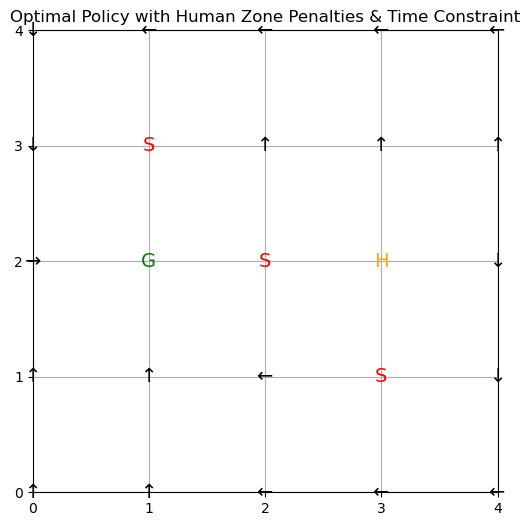

In [5]:
import numpy as np
import mdptoolbox
import matplotlib.pyplot as plt
import random

rows, cols = 5, 5
num_states = rows * cols
shelves = [(1, 1), (2, 2), (3, 3)]
human_zones = [(2, 1), (2, 3)]  # Human worker zones
actions = ['up', 'down', 'left', 'right']
num_actions = len(actions)
movement = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}

def to_index(x, y):
    return x * cols + y

def set_dynamic_goal():
    possible = [(i, j) for i in range(rows) for j in range(cols) if (i, j) not in shelves]
    return random.choice(possible)

goal_state = set_dynamic_goal()
print("Current Goal Position:", goal_state)

P = [np.zeros((num_states, num_states)) for _ in range(num_actions)]
R = np.zeros((num_states, num_actions))

for action_idx, action in enumerate(actions):
    dx, dy = movement[action]
    for x in range(rows):
        for y in range(cols):
            current_state = to_index(x, y)

            if (x, y) == goal_state:
                P[action_idx][current_state, current_state] = 1
                R[current_state, action_idx] = 10
                continue

            outcomes = []

            # Intended move
            new_x, new_y = x + dx, y + dy
            if (new_x, new_y) in shelves or not (0 <= new_x < rows and 0 <= new_y < cols):
                new_state = current_state
                reward = -5 if (new_x, new_y) in shelves else -1
            else:
                new_state = to_index(new_x, new_y)
                reward = -1

            if (new_x, new_y) in human_zones:
                reward -= 10  # heavy penalty for entering human zones

            outcomes.append((new_state, 0.9, reward))

            # Misstep moves
            other_actions = [a for i, a in enumerate(actions) if i != action_idx]
            for mis_action in other_actions:
                mx, my = movement[mis_action]
                new_x, new_y = x + mx, y + my
                if (new_x, new_y) in shelves or not (0 <= new_x < rows and 0 <= new_y < cols):
                    mis_state = current_state
                    mis_reward = -5 if (new_x, new_y) in shelves else -1
                else:
                    mis_state = to_index(new_x, new_y)
                    mis_reward = -1

                if (new_x, new_y) in human_zones:
                    mis_reward -= 10

                outcomes.append((mis_state, 0.1 / 3, mis_reward))

            for s_next, prob, rew in outcomes:
                P[action_idx][current_state, s_next] += prob
                R[current_state, action_idx] += prob * rew

# Simulate time constraint by limiting iterations and slightly lowering discount factor
vi = mdptoolbox.mdp.ValueIteration(P, R, 0.85, max_iter=50)
vi.run()

policy_grid = np.array(vi.policy).reshape((rows, cols))
action_symbols = ['↑', '↓', '←', '→']
policy_symbols = np.array([[action_symbols[a] for a in row] for row in policy_grid])
print("\nOptimal Policy Avoiding Human Zones with Time Constraint:")
print(policy_symbols)

plt.figure(figsize=(6, 6))
for x in range(rows):
    for y in range(cols):
        idx = to_index(x, y)
        if (x, y) == goal_state:
            plt.text(y, rows - x - 1, 'G', ha='center', va='center', fontsize=14, color='green')
        elif (x, y) in shelves:
            plt.text(y, rows - x - 1, 'S', ha='center', va='center', fontsize=14, color='red')
        elif (x, y) in human_zones:
            plt.text(y, rows - x - 1, 'H', ha='center', va='center', fontsize=14, color='orange')
        else:
            plt.text(y, rows - x - 1, action_symbols[vi.policy[idx]], ha='center', va='center', fontsize=14)
plt.xticks(range(cols))
plt.yticks(range(rows))
plt.grid(True)
plt.title("Optimal Policy with Human Zone Penalties & Time Constraint")
plt.show()
